In [1]:
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import numpy as np

from torch import multiprocessing

%reload_ext autoreload
%autoreload 2

from cuda_square_simulation import SquareSimulation

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def clever_single_action(env, action_batch, obs_indices):
    # By default, random actions
    actions = env.get_random_action_grid()
    
    batch_idx, x_idx, y_idx = obs_indices.T

    # Now assign:
    actions[batch_idx, x_idx, y_idx] = action_batch.float()
    
    return actions

# Unstable REINFORCE

In [2]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

print(f"Using device: {device}")

num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 5e-3
max_grad_norm = 1.0

sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)

Using device: cuda:0


In [3]:
# Define the observation shape as returned by get_deep_observations.
# For example, if your simulation returns patches of shape (C, obs_size, obs_size)
# and C = number_of_populations (say 3) and obs_size is 5:
obs_shape = (3, 5, 5)

# Simple policy network for a discrete action space (0 to 16):
class PolicyNet(nn.Module):
    def __init__(self, obs_shape, num_actions=17):        
        super().__init__()
        
        self.saved_log_probs = []
        self.rewards = []
        
        self.all_rewards = []
        self.all_losses = []
        self.action_counts = [0] * num_actions
        
        C, H, W = obs_shape
        # Flatten the observation
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(C * H * W, 100)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(100, num_actions)
        #self.fc3 = nn.Linear(100, num_actions)
        
    def forward(self, x):
        # x shape: (batch, C, H, W)
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        
        x = self.dropout(x)  # Apply dropout
        
        
        #x = torch.relu(self.fc2(x))
        logits = self.fc2(x)
        
        probs = F.softmax(logits, dim=-1)  # Convert logits to probabilities

        return probs

# Create the policy and the corresponding optimizer:
policy_net = PolicyNet(obs_shape).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr)


In [109]:
nb_batches = 50
rows, cols = 50, 50
populations = {
    "red": {"p": 0.1, "mean_v": 1.0, "std_v": 0.2},
    "blue": {"p": 0.1, "mean_v": 1.0, "std_v": 0.2},
    "green": {"p": 0.1, "mean_v": 1.0, "std_v": 0.2},
}

gamma = 0.98

clever_pop_id = 0  # Clever population ID

simulation = SquareSimulation(nb_batch=nb_batches, rows=rows, cols=cols, populations=populations, device=device)
simulation.reset()

In [ ]:
from itertools import count
from collections import deque

def select_action(observations):
    probs = policy_net(observations)
    m = Categorical(probs)
    
    action = m.sample()  # Size: (batch_size,)
    
    unique, counts = torch.unique(action, return_counts=True)
    for u, c in zip(unique.tolist(), counts.tolist()):
        policy_net.action_counts[u] += c / 10000
    
    policy_net.saved_log_probs.append(m.log_prob(action))
    return action

def finish_episode():
    R = 0
    policy_loss = []
    returns = deque()
    for r in policy_net.rewards[::-1]:
        R = r + gamma * R
        returns.appendleft(R)
        
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + simulation.EPS)
    for log_prob, R in zip(policy_net.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
        
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    
    policy_net.all_losses.append(policy_loss.item())
    policy_net.all_rewards.append(R.item())
    
    policy_loss.backward()
    optimizer.step()
    
    del policy_net.rewards[:]
    del policy_net.saved_log_probs[:]

In [111]:
learn_steps = 50
running_reward = 0
nb_epochs = 10

for i_episode in tqdm(range(nb_epochs)):
    simulation.reset()
    ep_reward = 0
    
    for t in tqdm(range(750), leave=False):
        observations, obs_indices = simulation.get_deep_observations(clever_pop_id)
        
        action = select_action(observations)
        all_actions_grid = clever_single_action(simulation, action, obs_indices) 
        
        rewards, done, info = simulation.step(all_actions_grid)
        
        clever_pop_rewards = rewards[clever_pop_id]
        policy_net.rewards.append(clever_pop_rewards)
        ep_reward += clever_pop_rewards
        
        if t % 5 == 0 and t > 0:
            # Update the policy every 50 steps           
            finish_episode()
            
    running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
    print(f"Episode {i_episode} - Time {t} - Running reward: {running_reward:.2f} - Avg reward: {ep_reward:.2f} - Loss: {policy_net.all_losses[-1]:.2f} - Action counts: {100 *np.array(policy_net.action_counts) / np.sum(policy_net.action_counts)}")
            

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Episode 0 - Time 749 - Running reward: -0.25 - Avg reward: -5.02 - Loss: 0.20 - Action counts: [5.28470387 5.5949285  6.1041607  6.82778155 6.25300227 6.09374889
 5.37746364 6.12356453 5.34906779 5.55162483 6.6451016  5.57741773
 5.87841371 6.02062958 6.04997196 5.69052786 5.57789099]


  0%|          | 0/750 [00:00<?, ?it/s]

Episode 1 - Time 749 - Running reward: -0.49 - Avg reward: -5.00 - Loss: -13.22 - Action counts: [4.96700711 5.62360939 6.07691081 6.49271777 7.03941859 7.12282695
 4.58106103 7.71308422 4.41503012 5.00674676 7.74417994 4.85250304
 8.13472864 5.17524736 6.04749898 4.41233591 4.59509339]


  0%|          | 0/750 [00:00<?, ?it/s]

Episode 2 - Time 749 - Running reward: -0.65 - Avg reward: -3.71 - Loss: 158.58 - Action counts: [ 0.64126915  0.65534798  2.05128093  0.7325292   2.44810083  3.73640981
  1.69411915 81.97464268  0.60457141  0.6257033   0.7862184   0.46827136
  0.95553277  0.93786602  0.7863139   0.35446743  0.54735567]


  0%|          | 0/750 [00:00<?, ?it/s]

Episode 3 - Time 749 - Running reward: 2.52 - Avg reward: 62.75 - Loss: 9.57 - Action counts: [1.34333889e-01 1.37213503e-01 4.29753375e-01 1.53337624e-01
 5.12932369e-01 7.83794479e-01 3.75082125e-01 9.62035704e+01
 1.26607331e-01 1.30993138e-01 1.64570543e-01 9.80153554e-02
 2.00013914e-01 1.96381918e-01 1.64596241e-01 7.41932296e-02
 1.14610608e-01]


  0%|          | 0/750 [00:00<?, ?it/s]

Episode 4 - Time 749 - Running reward: 5.53 - Avg reward: 62.67 - Loss: -17.90 - Action counts: [7.49521357e-02 7.65429825e-02 2.39758454e-01 8.55235438e-02
 2.86234590e-01 4.37603109e-01 2.10616019e-01 9.78804076e+01
 7.06326441e-02 7.30666876e-02 9.17826264e-02 5.46644593e-02
 1.11557537e-01 1.09551064e-01 9.18017356e-02 4.13795346e-02
 6.39252899e-02]


  0%|          | 0/750 [00:00<?, ?it/s]

Episode 5 - Time 749 - Running reward: 8.36 - Avg reward: 62.16 - Loss: -13.82 - Action counts: [5.20340103e-02 5.31297598e-02 1.66446171e-01 5.93555840e-02
 1.98715248e-01 3.03900568e-01 1.46837063e-01 9.85279415e+01
 4.90274682e-02 5.07122590e-02 6.36993494e-02 3.79379086e-02
 7.74241229e-02 7.60421413e-02 6.37104008e-02 2.87176989e-02
 4.43687370e-02]


  0%|          | 0/750 [00:00<?, ?it/s]

Episode 6 - Time 749 - Running reward: 11.11 - Avg reward: 63.42 - Loss: -22.74 - Action counts: [3.98359031e-02 4.06691132e-02 1.27420668e-01 4.54340601e-02
 1.52128097e-01 2.32679638e-01 1.12528200e-01 9.88729716e+01
 3.75316753e-02 3.88195559e-02 4.87575957e-02 2.90384303e-02
 5.92632335e-02 5.82138963e-02 4.87656318e-02 2.19810983e-02
 3.39615602e-02]


  0%|          | 0/750 [00:00<?, ?it/s]

Episode 7 - Time 749 - Running reward: 13.70 - Avg reward: 62.83 - Loss: -5.31 - Action counts: [3.22686686e-02 3.29418103e-02 1.03216782e-01 3.67997861e-02
 1.23230845e-01 1.88506754e-01 9.12167025e-02 9.90869968e+01
 3.04010000e-02 3.14441128e-02 3.94913254e-02 2.35198812e-02
 4.80003168e-02 4.71538368e-02 3.94985193e-02 1.78034860e-02
 2.75094022e-02]


  0%|          | 0/750 [00:00<?, ?it/s]

Episode 8 - Time 749 - Running reward: 16.17 - Avg reward: 63.05 - Loss: 4.63 - Action counts: [2.71176054e-02 2.76835691e-02 8.67438649e-02 3.09253376e-02
 1.03565595e-01 1.58434996e-01 7.66912446e-02 9.92326753e+01
 2.55489706e-02 2.64244007e-02 3.31877529e-02 1.97649715e-02
 4.03374345e-02 3.96269572e-02 3.31929347e-02 1.49611893e-02
 2.31178601e-02]


  0%|          | 0/750 [00:00<?, ?it/s]

Episode 9 - Time 749 - Running reward: 18.49 - Avg reward: 62.59 - Loss: -6.98 - Action counts: [2.33832815e-02 2.38702832e-02 7.47972111e-02 2.66649583e-02
 8.93047494e-02 1.36635013e-01 6.61572741e-02 9.93383106e+01
 2.20300024e-02 2.27843339e-02 2.86161920e-02 1.70420820e-02
 3.47806609e-02 3.41695507e-02 2.86201635e-02 1.29000851e-02
 1.99335617e-02]


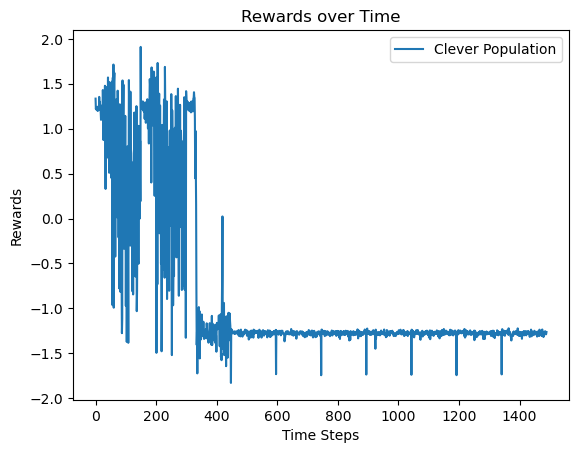

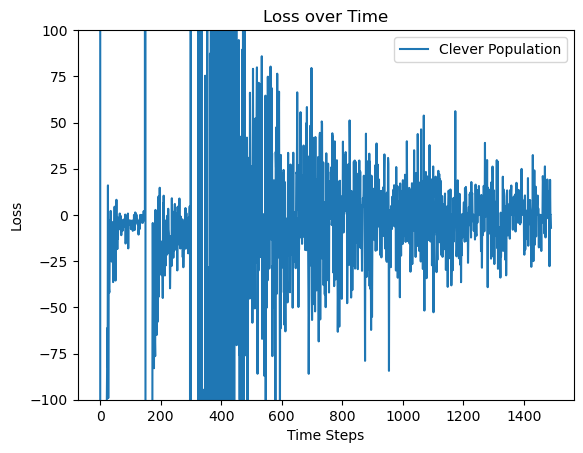

In [115]:
# Plot the rewards
plt.plot(policy_net.all_rewards, label="Clever Population")
plt.xlabel("Time Steps")
plt.ylabel("Rewards")
plt.title("Rewards over Time")
plt.legend()
plt.show()

plt.plot(policy_net.all_losses, label="Clever Population")
plt.xlabel("Time Steps")
plt.ylabel("Loss")
plt.title("Loss over Time")
plt.ylim(-100, 100)
plt.legend()

In [116]:
# Store model
torch.save(policy_net.state_dict(), "policy_net.pth")

# Stable REINFORCE

In [17]:
nb_batches = 250
rows, cols = 20, 20
populations = {
    "red": {"p": 0.1, "mean_v": 1.0, "std_v": 0.2},
    "blue": {"p": 0.1, "mean_v": 1.0, "std_v": 0.2},
    "green": {"p": 0.1, "mean_v": 1.0, "std_v": 0.2},
}

obs_shape = (3, 6, 6)

device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

clever_pop_id = 0  # Clever population ID

simulation = SquareSimulation(nb_batch=nb_batches, rows=rows, cols=cols, populations=populations, device=device)
simulation.reset()

Using device: cuda:0


In [18]:
simulation = SquareSimulation(nb_batch=nb_batches, rows=rows, cols=cols, populations=populations, device=device)
simulation.reset()

# ──────────────────────────────────────────────────────────────────────────────
# 1. Hyper‑parameters
# ──────────────────────────────────────────────────────────────────────────────
gamma           = 0.98          # already in your code
gae_lambda      = 0.95          # controls bias / variance trade‑off
entropy_coef    = 0.01          # ↑ → more exploration
value_coef      = 0.5           # weight of the value loss
max_grad_norm   = 1.0           # gradient clipping
lr              = 1e-4          # learning rate

nb_epochs      = 50            # number of epochs per batch

# ──────────────────────────────────────────────────────────────────────────────
# 2. Network: policy *and* value in a single model
# ──────────────────────────────────────────────────────────────────────────────
class ActorCritic(nn.Module):
    def __init__(self, obs_shape, num_actions=17):
        super().__init__()
        C, H, W = obs_shape
        
        self.action_counts = [0] * num_actions

        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(C * H * W, 100)
        self.dropout = nn.Dropout(0.1)

        self.pi_head = nn.Linear(100, num_actions)   # policy logits
        self.v_head  = nn.Linear(100, 1)             # state‑value

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        logits = self.pi_head(x)
        value  = self.v_head(x).squeeze(-1)          # (batch,) not (batch,1)
        probs  = F.softmax(logits, dim=-1)
        return probs, value
    
class ActorCriticCNN(nn.Module):
    """
    A minimal convolutional encoder followed by separate policy and value heads.
    Works with any (C, H, W) observation size – the AdaptiveAvgPool2d collapses
    spatial dimensions so no manual shape maths is needed.
    """
    def __init__(self, obs_shape, num_actions=17):
        super().__init__()
        C, H, W = obs_shape            # H, W only needed for comments
        
        self.action_counts = [0] * num_actions

        # ─── convolutional trunk ────────────────────────────────────────────
        self.features = nn.Sequential(
            nn.Conv2d(C, 16, kernel_size=3, stride=1, padding=1),  # (H, W) → (H, W)
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # (H, W) → (H, W)
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))                           # (H, W) → (1, 1)
        )
        # output shape is (batch, 64, 1, 1) → flatten to 64 dim
        self.flat = nn.Flatten()

        # ─── heads ─────────────────────────────────────────────────────────-
        self.policy_head = nn.Linear(32, num_actions)   # logits π(a|s)
        self.value_head  = nn.Linear(32, 1)             # V(s)

    def forward(self, x):
        """
        x : Tensor  shape (batch, C, H, W)
        Returns:
            probs  : (batch, num_actions)
            values : (batch,)  – squeezed to 1‑D
        """
        x = self.features(x)          # (B, 64, 1, 1)
        x = self.flat(x)              # (B, 64)

        logits = self.policy_head(x)  # (B, num_actions)
        value  = self.value_head(x).squeeze(-1)  # (B,)

        probs = F.softmax(logits, dim=-1)
        return probs, value

policy_net = ActorCriticCNN(obs_shape).to(device)
optimizer  = optim.Adam(policy_net.parameters(), lr)

# ──────────────────────────────────────────────────────────────────────────────
# 3. Storage helpers
# ──────────────────────────────────────────────────────────────────────────────
log_probs_buffer, values_buffer, rewards_buffer, entropies_buffer = [], [], [], []

def select_action(obs):
    obs       = obs.to(device)
    probs, V  = policy_net(obs)               # forward pass
    m         = Categorical(probs)
    action    = m.sample()
    
    # update action counts
    unique, counts = torch.unique(action, return_counts=True)
    for u, c in zip(unique.tolist(), counts.tolist()):
        policy_net.action_counts[u] += c / 10000

    log_probs_buffer.append(m.log_prob(action).mean())
    values_buffer.   append(V.mean())                # save the *state*-value
    entropies_buffer.append(m.entropy().mean())      # for entropy bonus

    return action                             # (batch,)

# ──────────────────────────────────────────────────────────────────────────────
# 4. Finish episode with GAE
# ──────────────────────────────────────────────────────────────────────────────
def finish_episode(next_value=0.0):
    """
    Compute advantages (GAE‑λ) and returns, then do one optimiser step.
    Pass `next_value=V(s_{T})` if you end in a non‑terminal state – here the
    episode terminates at fixed length, so we set it to 0 by default.
    """
    # 4.1 Stack episode tensors: shape (T,batch)
    log_probs = torch.stack(log_probs_buffer)        # detach not needed
    values    = torch.stack(values_buffer)
    rewards   = torch.stack(rewards_buffer)
    entropies = torch.stack(entropies_buffer)

    # 4.2 Generalised Advantage Estimation (vectorised)
    T = rewards.size(0)                     # number of time steps in the episode

    advantages = torch.zeros_like(rewards)
    gae = 0
    with torch.no_grad():
        next_V = next_value
        for t in reversed(range(T)):
            delta = rewards[t] + gamma * next_V - values[t]
            gae   = delta + gamma * gae_lambda * gae
            advantages[t] = gae
            next_V = values[t]

    returns = advantages + values               # targets for the value head

    # 4.3 (Optionally) centre the advantages with the *mean return*
    advantages = advantages - advantages.mean()

    # 4.4 Losses
    policy_loss = -(log_probs * advantages).mean()
    value_loss  = F.mse_loss(values, returns)
    entropy_loss= -entropies.mean()             # (minus) so we *subtract* later

    loss = policy_loss + value_coef * value_loss + entropy_coef * entropy_loss

    # 4.5 Back‑prop + clip
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_grad_norm)
    optimizer.step()

    # 4.6 Clear buffers for next trajectory
    log_probs_buffer.clear()
    values_buffer.   clear()
    rewards_buffer.  clear()
    entropies_buffer.clear()

# ──────────────────────────────────────────────────────────────────────────────
# 5. Training loop – only differences marked with (★)
# ──────────────────────────────────────────────────────────────────────────────
for i_episode in tqdm(range(nb_epochs)):
    simulation.reset()
    ep_reward = 0.0

    for t in tqdm(range(500), leave=False):
        obs_batch, obs_indices = simulation.get_deep_observations(clever_pop_id)

        action_batch   = select_action(obs_batch)
        action_grid    = clever_single_action(simulation, action_batch, obs_indices)
        rewards, done, info = simulation.step(action_grid)

        r_global = rewards[clever_pop_id].mean()                        # (batch,)
        rewards_buffer.append(r_global)
        ep_reward += r_global.item()                       # scalar for logging

        # ★ update only at episode end
    finish_episode()                                       # GAE uses boot‑strap V=0

    print(f"Episode {i_episode} | reward {ep_reward:.2f} | action counts {100 *np.array(policy_net.action_counts) / np.sum(policy_net.action_counts)}")



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Episode 0 | reward -24.90 | action counts [6.69538108 5.4292367  5.32073565 5.24959723 5.95350895 6.71660305
 6.5402515  5.56105201 4.96564134 5.54222125 6.73483601 6.26825164
 4.85474909 6.18993959 6.65682286 5.6525157  5.66865635]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 1 | reward -25.40 | action counts [6.67153224 5.45755637 5.31799111 5.2272239  5.95606469 6.70382716
 6.51532159 5.56283495 4.98778626 5.58972367 6.72602102 6.27446127
 4.84637152 6.19422191 6.65943943 5.65673207 5.65289082]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 2 | reward -24.77 | action counts [6.66168851 5.44605607 5.33077404 5.21719989 5.96857307 6.69375874
 6.5221166  5.56959287 5.005043   5.61940609 6.69964144 6.30417188
 4.85085921 6.18898473 6.62506393 5.66143897 5.63563097]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 3 | reward -25.04 | action counts [6.6737902  5.43018756 5.32606331 5.20420202 5.95985687 6.70122156
 6.53239665 5.55456219 5.00966919 5.6130872  6.69849278 6.3056212
 4.8446502  6.20444115 6.64398912 5.66443123 5.63333757]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 4 | reward -24.91 | action counts [6.67331712 5.42541419 5.33530753 5.20066147 5.97153589 6.69061897
 6.54381022 5.53830446 5.01119766 5.60756896 6.69610075 6.29655939
 4.85559523 6.20034284 6.64465202 5.67026675 5.63874655]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 5 | reward -24.83 | action counts [6.68412936 5.41680471 5.3402485  5.21626176 5.96523509 6.68126923
 6.52901485 5.53707327 5.02010435 5.60161693 6.69223307 6.30563851
 4.85702913 6.20110067 6.63665117 5.66434916 5.65124022]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 6 | reward -24.89 | action counts [6.69004273 5.41673811 5.34621421 5.2099477  5.96427724 6.68072748
 6.52335738 5.53132399 5.00859806 5.60691769 6.69230972 6.30453134
 4.85914181 6.20758674 6.63967441 5.66136659 5.65724479]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 7 | reward -24.83 | action counts [6.68883845 5.42118272 5.3499369  5.19960929 5.96327211 6.67598315
 6.51460576 5.52171409 5.01212407 5.61773165 6.69273838 6.30455154
 4.86132702 6.21293944 6.64503653 5.66276133 5.65564758]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 8 | reward -24.81 | action counts [6.69099472 5.42075339 5.35302688 5.20264833 5.96214826 6.67600501
 6.51092564 5.51788157 5.01083143 5.61584428 6.69542422 6.30784238
 4.86054918 6.21302525 6.65074398 5.66126278 5.65009271]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 9 | reward -24.50 | action counts [6.69312692 5.42127602 5.35373208 5.20672639 5.96695004 6.67571302
 6.51421503 5.51586646 5.01092129 5.61525874 6.69859407 6.30510363
 4.85905591 6.21164134 6.64803013 5.65572725 5.64806166]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 10 | reward -24.99 | action counts [6.69562085 5.42449982 5.35125679 5.21149123 5.9688872  6.67419924
 6.50833921 5.5148854  5.01181864 5.61275279 6.69842982 6.30772155
 4.85792952 6.21652216 6.6478685  5.65168448 5.64609281]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 11 | reward -24.74 | action counts [6.70347754 5.42364054 5.35374006 5.20969541 5.96473631 6.67039598
 6.51077502 5.51208309 5.01084434 5.60886837 6.7021755  6.30536551
 4.8551054  6.21788743 6.6498285  5.65407823 5.64730278]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 12 | reward -25.35 | action counts [6.70614199 5.42285678 5.35545357 5.2135977  5.96188238 6.66833748
 6.51449536 5.51171962 5.01303366 5.60998911 6.6997597  6.30423557
 4.85423248 6.21993152 6.65412743 5.64968384 5.64052181]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 13 | reward -24.80 | action counts [6.70415966 5.41994336 5.35591648 5.21424307 5.95677297 6.67078219
 6.51654314 5.51203625 5.00829477 5.60966793 6.70194827 6.30292732
 4.85180299 6.22424742 6.65013569 5.66065383 5.63992466]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 14 | reward -25.37 | action counts [6.70429257 5.41200556 5.35270672 5.21442624 5.95852163 6.67006911
 6.51482134 5.51015004 5.00856549 5.61191523 6.70610293 6.30682283
 4.84865701 6.22859228 6.6518885  5.66123784 5.63922467]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 15 | reward -25.31 | action counts [6.70428385 5.41343535 5.35369975 5.21609129 5.95683083 6.67044571
 6.51663104 5.50958982 5.00535635 5.61159152 6.70428385 6.31125606
 4.8463261  6.22760817 6.6512076  5.65970485 5.64165784]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 16 | reward -25.12 | action counts [6.70575827 5.41286491 5.35406464 5.21788756 5.95881165 6.67724031
 6.51724454 5.50915756 5.00735343 5.61176114 6.69676688 6.308356
 4.84267535 6.22826481 6.64962149 5.65968692 5.64248453]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 17 | reward -24.58 | action counts [6.70694299 5.41466011 5.35067824 5.21377598 5.96011877 6.67523289
 6.52204229 5.50834613 5.0075159  5.60671805 6.6940086  6.31058278
 4.84633359 6.22808196 6.65276622 5.66216258 5.64003291]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 18 | reward -24.56 | action counts [6.70283966 5.41465192 5.35103546 5.21519667 5.96133688 6.67842091
 6.52423006 5.50706608 5.00293907 5.60697616 6.69076713 6.31283912
 4.84528154 6.23204135 6.6518583  5.66659379 5.63592591]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 19 | reward -24.94 | action counts [6.70422699 5.41167343 5.3521508  5.21705739 5.96183496 6.68081986
 6.52158198 5.50748508 5.00259083 5.60692562 6.69462703 6.31052745
 4.84842763 6.22921696 6.64801518 5.66686753 5.63597128]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 20 | reward -25.32 | action counts [6.70582331 5.41081149 5.35113727 5.21679108 5.96026052 6.68223182
 6.52313729 5.50374517 5.00322816 5.60996886 6.6925333  6.31062105
 4.84863709 6.22827806 6.64833884 5.66675095 5.63770573]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 21 | reward -25.39 | action counts [6.70261059 5.40998338 5.34940624 5.21796552 5.95841839 6.6820246
 6.52459226 5.5006326  5.00407587 5.61401957 6.69303266 6.31302492
 4.85043534 6.23033982 6.64851495 5.66525495 5.63566832]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 22 | reward -24.98 | action counts [6.69943999 5.41225315 5.35171922 5.21852951 5.95894083 6.68295127
 6.52484025 5.50036867 5.00400046 5.6155262  6.69091956 6.31176682
 4.85011828 6.22785505 6.64620928 5.66706286 5.63749861]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 23 | reward -24.99 | action counts [6.70216115 5.41011803 5.34994417 5.21770833 5.96111874 6.68167848
 6.52905613 5.49999417 5.00386634 5.61736084 6.69089808 6.31256967
 4.84922457 6.22679247 6.64605017 5.66639184 5.63506682]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 24 | reward -24.88 | action counts [6.70570335 5.40946613 5.34769334 5.21880978 5.96083273 6.68542371
 6.5277751  5.49864355 5.00126762 5.61574438 6.68847891 6.3130691
 4.84976402 6.22652031 6.64684741 5.6691586  5.63480195]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 25 | reward -24.75 | action counts [6.70389694 5.41057257 5.34648968 5.21811339 5.96147049 6.68652453
 6.52842238 5.49813258 5.00069246 5.61600565 6.68690123 6.31440281
 4.84651239 6.22659905 6.64694914 5.66979584 5.63851887]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 26 | reward -24.56 | action counts [6.70471745 5.41205404 5.34477852 5.21665554 5.96305023 6.68904835
 6.52998291 5.49802553 4.9978336  5.61499297 6.68608566 6.31302201
 4.84508928 6.2285479  6.64614817 5.67032147 5.6396464 ]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 27 | reward -24.64 | action counts [6.70525079 5.41268675 5.3433501  5.21583382 5.96378827 6.68798371
 6.53163049 5.49847512 4.99955671 5.61218187 6.68719932 6.31294858
 4.84440072 6.22993657 6.64528563 5.67125942 5.63823214]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 28 | reward -25.12 | action counts [6.70583939 5.4136077  5.34458134 5.21487793 5.96537025 6.68678939
 6.53328345 5.49855556 4.99886168 5.61370245 6.68437825 6.31181723
 4.84496717 6.23047612 6.64384718 5.67032439 5.63872052]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 29 | reward -25.07 | action counts [6.70765584 5.41148223 5.34621658 5.21636905 5.96699621 6.68743187
 6.53405712 5.49914833 5.0001459  5.61195957 6.68387823 6.31124673
 4.84411314 6.22828993 6.64449927 5.66895265 5.63755734]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 30 | reward -25.26 | action counts [6.70842763 5.40997475 5.3456238  5.21615716 5.96544466 6.68810579
 6.53510908 5.49900289 4.99938773 5.6101808  6.68504679 6.30962896
 4.8455983  6.22892915 6.64619374 5.66749045 5.6396983 ]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 31 | reward -25.22 | action counts [6.7075474  5.41081848 5.34610518 5.21647108 5.96676824 6.6872574
 6.53528535 5.50019735 4.99781898 5.61136385 6.68516434 6.30864896
 4.84618976 6.22797612 6.64744424 5.66761471 5.63732856]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 32 | reward -25.34 | action counts [6.70764337 5.4081585  5.34659898 5.21743595 5.9678533  6.68765708
 6.53565633 5.49936945 4.99888129 5.61077661 6.68568907 6.31132882
 4.84439647 6.22821735 6.64678359 5.66755166 5.63600219]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 33 | reward -24.84 | action counts [6.70795424 5.40726911 5.34519433 5.21659813 5.96606092 6.68972641
 6.53647001 5.50005456 4.99716824 5.61115272 6.68469423 6.31040411
 4.84627094 6.22966022 6.64895987 5.66702426 5.6353377 ]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 34 | reward -24.20 | action counts [6.70811186 5.40785707 5.34556625 5.21760749 5.96540283 6.69123455
 6.53706807 5.49887399 4.99745932 5.61036003 6.68548768 6.30877024
 4.84590206 6.22954431 6.64757153 5.66872877 5.63445396]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 35 | reward -24.86 | action counts [6.70856063 5.40729211 5.34597428 5.2167743  5.96516319 6.68992694
 6.53743084 5.49967411 4.99673309 5.61060955 6.68642009 6.30770364
 4.84629937 6.22905215 6.64896012 5.66975265 5.63367295]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 36 | reward -25.26 | action counts [6.70986299 5.40677364 5.34588825 5.21626181 5.96543238 6.69009105
 6.53749105 5.49963615 4.99614674 5.61060732 6.68606951 6.30913767
 4.84603775 6.22652034 6.64954765 5.67040727 5.63408844]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 37 | reward -25.09 | action counts [6.70958446 5.40649421 5.34533218 5.21784794 5.96408098 6.68689189
 6.53755864 5.49762929 4.99628757 5.61270328 6.68680069 6.30945496
 4.84597397 6.22761426 6.6511735  5.67049867 5.63407351]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 38 | reward -24.86 | action counts [6.7099867  5.40606568 5.34441562 5.21925563 5.96420621 6.68696426
 6.53678856 5.49739225 4.99467009 5.6121488  6.68664563 6.30900937
 4.84587262 6.22913105 6.65133764 5.67144252 5.63466737]


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 39 | reward -25.14 | action counts [6.71029686 5.40470941 5.34429882 5.22015201 5.96429543 6.68688739
 6.53650434 5.49683629 4.99534016 5.61308113 6.68685125 6.30940071
 4.84607047 6.22843634 6.65132496 5.6712144  5.63430003]


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
# ═════════════════════════════════════════════════════════════════════════════
# 0.  Hyper‑parameters (tweak as you like)
# ═════════════════════════════════════════════════════════════════════════════
gamma            = 0.99
gae_lambda       = 0.95
clip_epsilon     = 0.20
entropy_coef     = 0.01
value_coef       = 0.5
max_grad_norm    = 1.0

rollout_len      = 500      # env steps per episode (= rollout)
ppo_epochs       = 4        # optimisation passes per rollout
minibatch_size   = 4096     # samples per minibatch (after flattening)

# ═════════════════════════════════════════════════════════════════════════════
# 1.  CNN‑based actor‑critic (unchanged from previous answer)
# ═════════════════════════════════════════════════════════════════════════════
class ActorCriticCNN(nn.Module):
    def __init__(self, obs_shape, num_actions=17):
        super().__init__()
        C, _, _ = obs_shape
        self.features = nn.Sequential(
            nn.Conv2d(C, 32, 3, 1, 1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.flat         = nn.Flatten()
        self.policy_head  = nn.Linear(64, num_actions)
        self.value_head   = nn.Linear(64, 1)

    def forward(self, x):
        x = self.flat(self.features(x))
        logits = self.policy_head(x)
        value  = self.value_head(x).squeeze(-1)
        probs  = F.softmax(logits, dim=-1)
        return probs, value

policy_net = ActorCriticCNN(obs_shape).to(device)
optimizer  = optim.Adam(policy_net.parameters(), lr)

# ═════════════════════════════════════════════════════════════════════════════
# 2.  Roll‑out buffers (lists of tensors)
# ═════════════════════════════════════════════════════════════════════════════
obs_buf, act_buf, logp_buf, val_buf, rew_buf = [], [], [], [], []

def select_action(obs_batch):
    obs_batch = obs_batch.to(device)
    probs, values = policy_net(obs_batch)      # logits → dist
    dist   = Categorical(probs)
    action = dist.sample()

    # ─── store step data ────────────────────────────────────────────────────
    obs_buf .append(obs_batch.detach())        # (B, C, H, W)
    act_buf .append(action.detach())           # (B,)
    logp_buf.append(dist.log_prob(action).detach())
    val_buf .append(values.detach())
    return action

# ═════════════════════════════════════════════════════════════════════════════
# 3.  Helper: pad variable‑length batches then mask
# ═════════════════════════════════════════════════════════════════════════════
def _pad(seq, B_max=None):
    """
    Pad a list of 0‑D / 1‑D / 2‑D tensors along dim0.
    If B_max is given, use it for the second dimension so *every* buffer
    ends up with the same width.
    Returns padded tensor and boolean mask.
    """
    seq = [s.unsqueeze(0) if s.dim() == 0 else s for s in seq]

    if B_max is None:
        B_max = max(s.size(0) for s in seq)

    T     = len(seq)
    base  = seq[0]
    pad   = torch.zeros((T, B_max, *base.shape[1:]),
                        dtype=base.dtype, device=base.device)
    mask  = torch.zeros(T, B_max, dtype=torch.bool, device=base.device)

    for t, s in enumerate(seq):
        L = s.size(0)
        pad[t, :L]  = s
        mask[t, :L] = True

    return pad, mask



# ═════════════════════════════════════════════════════════════════════════════
# 4.  GAE + PPO update (called once per rollout)
# ═════════════════════════════════════════════════════════════════════════════
def ppo_update():
    # ---------------------------------------------------------------------
    # 2‑A  determine the global B_max across *all* rollout buffers
    # ---------------------------------------------------------------------
    candidates = obs_buf + val_buf + rew_buf           # lists of tensors
    B_max_glob = max(t.size(0) if t.dim() else 1       # 0‑D → size 1
                     for t in candidates)

    # ---------------------------------------------------------------------
    # 2‑B  pad every buffer with *the same* B_max_glob
    # ---------------------------------------------------------------------
    rew_pad,  mask = _pad(rew_buf,  B_max_glob)        # (T, B_max)
    obs_pad,  _    = _pad(obs_buf,  B_max_glob)        # (T, B_max, C, H, W)
    act_pad,  _    = _pad(act_buf,  B_max_glob)        # (T, B_max)
    logp_pad, _    = _pad(logp_buf, B_max_glob)        # (T, B_max)
    val_pad,  _    = _pad(val_buf, B_max_glob)         # (T, B_max)

    T, B = mask.shape
    advantages = torch.zeros_like(rew_pad)
    gae        = torch.zeros(B, device=device)

    # ---------------------------------------------------------------------
    # 2‑C  cell‑wise GAE with masking (unchanged)
    # ---------------------------------------------------------------------
    for t in reversed(range(T)):
        valid   = mask[t]
        delta   = rew_pad[t] + gamma * gae * valid - val_pad[t]
        gae     = delta + gamma * gae_lambda * gae
        gae    *= valid
        advantages[t] = gae

    returns_pad = advantages + val_pad

    # ---------------------------------------------------------------------
    # 2‑D  flatten only valid positions and continue (unchanged)
    # ---------------------------------------------------------------------
    flat_mask      = mask.view(-1)
    obs_flat       = obs_pad .view(-1, *obs_pad.shape[2:])[flat_mask]
    act_flat       = act_pad .view(-1)[flat_mask]
    logp_old_flat  = logp_pad.view(-1)[flat_mask]
    adv_flat       = advantages.view(-1)[flat_mask]
    ret_flat       = returns_pad.view(-1)[flat_mask]

    adv_flat = (adv_flat - adv_flat.mean()) / (adv_flat.std() + 1e-8)

    # PPO mini‑batch loops … (exactly as before)

# ═════════════════════════════════════════════════════════════════════════════
# 5.  Training loop
# ═════════════════════════════════════════════════════════════════════════════
for epi in tqdm(range(nb_epochs)):
    simulation.reset()
    ep_return = 0.0

    for t in range(rollout_len):
        obs_batch, obs_idx = simulation.get_deep_observations(clever_pop_id)

        action_batch   = select_action(obs_batch)            # uses old π
        grid_actions   = clever_single_action(simulation, action_batch, obs_idx)
        rewards, _, _  = simulation.step(grid_actions)

        # local (per‑cell) reward
        rew_buf.append(rewards[clever_pop_id].to(device))
        ep_return += rewards[clever_pop_id].mean().item()

    ppo_update()                                             # ← big update
    print(f"Episode {epi:03d} | return {ep_return:.3f}")


Episode 000 | return -24.799
Episode 001 | return -24.648
Episode 002 | return -24.901
Episode 003 | return -24.995
Episode 004 | return -25.013
Episode 005 | return -24.789
Episode 006 | return -25.180
Episode 007 | return -24.833
Episode 008 | return -24.966
Episode 009 | return -24.733
Episode 010 | return -24.603
Episode 011 | return -25.180


OutOfMemoryError: CUDA out of memory. Tried to allocate 308.00 MiB. GPU 0 has a total capacity of 31.74 GiB of which 43.12 MiB is free. Including non-PyTorch memory, this process has 31.69 GiB memory in use. Of the allocated memory 31.07 GiB is allocated by PyTorch, and 243.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)